<a href="https://colab.research.google.com/github/natexjake/OllopaCorporation/blob/main/OOP_Facedetection_Media_Pipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 44.6 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib

In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import mediapipe
import numpy as np
import pandas as pd

In [ ]:
def browse_photos():
    print('\n')
    print("Browsing photos...")
    uploaded = files.upload()

    # Iterate over the uploaded files
    for filename, file_content in uploaded.items():
        # Decode the file content as an image
        nparr = np.frombuffer(file_content, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        # Display the uploaded image
        # cv2_imshow(img)

        mp_face_mesh = mediapipe.solutions.face_mesh
        face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
        results = face_mesh.process(img[:,:,::-1])
        landmarks = results.multi_face_landmarks[0]

        face_oval = mp_face_mesh.FACEMESH_FACE_OVAL

        df = pd.DataFrame(list(face_oval), columns=["p1", "p2"])

        routes_idx = []

        p1 = df.iloc[0]["p1"]
        p2 = df.iloc[0]["p2"]

        for i in range(0, df.shape[0]):
            obj = df[df["p1"] == p2]
            p1 = obj["p1"].values[0]
            p2 = obj["p2"].values[0]

            current_route = []
            current_route.append(p1)
            current_route.append(p2)
            routes_idx.append(current_route)

        routes = []

        for source_idx, target_idx in routes_idx:
            source = landmarks.landmark[source_idx]
            target = landmarks.landmark[target_idx]

            relative_source = (int(source.x * img.shape[1]), int(source.y * img.shape[0]))
            relative_target = (int(target.x * img.shape[1]), int(target.y * img.shape[0]))

            routes.append(relative_source)
            routes.append(relative_target)

        mask = np.zeros((img.shape[0], img.shape[1]))
        mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
        mask = mask.astype(bool)

        out = np.zeros_like(img)
        out[mask] = img[mask]

        # Display the manipulated image
        cv2_imshow(out)

In [ ]:
def use_webcam():
    # Add your code here to use the webcam
    print("Using webcam...")

Face Detection Program
----------------------
1. Upload an image
2. Capture an image from the camera
Enter your choice (1 or 2): 1


Browsing photos...


Saving jane-480x504.jpg to jane-480x504.jpg


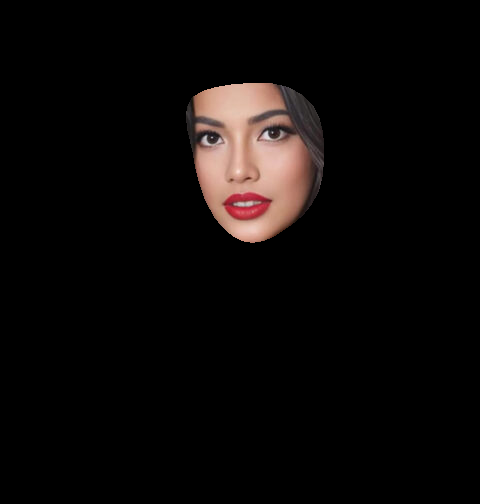

In [ ]:
def main():

  print("Face Detection Program")
  print("----------------------")
  print("1. Upload an image")
  print("2. Capture an image from the camera")
  choice = input("Enter your choice (1 or 2): ")

  if choice == "1":
    browse_photos()
  elif choice == "2":
    use_webcam()
  else:
    print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main()